In [ ]:
pip install gensim

In [ ]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [ ]:
print("Loading 20 Newsgroups dataset...")
categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
newsgroups = fetch_20newsgroups(subset='all', categories=categories)
texts = newsgroups.data
labels = newsgroups.target

Loading 20 Newsgroups dataset...


In [ ]:
print(f"Number of news articles: {len(texts)}")
print(f"Number of categories: {len(set(labels))}")

Number of news articles: 3387
Number of categories: 4


In [ ]:
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

In [ ]:
max_words = 10000
max_len = 200

In [ ]:
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print(f"Size of vocabulary: {len(word_index)}")

Size of vocabulary: 44591


In [ ]:
data = pad_sequences(sequences, maxlen=max_len)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
from gensim.models import Word2Vec

print("Training Word2Vec embeddings...")
sentences = [text.split() for text in texts]  # Simple tokenization
embedding_dim = 100
w2v_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)

Training Word2Vec embeddings...


In [ ]:
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= max_words:
        continue
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


In [ ]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Embedding(input_dim=max_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

None


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 272ms/step - accuracy: 0.3347 - loss: 1.3615 - val_accuracy: 0.4317 - val_loss: 1.1764
Epoch 2/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - accuracy: 0.4822 - loss: 1.1770 - val_accuracy: 0.5185 - val_loss: 1.1080
Epoch 3/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 351ms/step - accuracy: 0.5141 - loss: 1.0970 - val_accuracy: 0.5498 - val_loss: 1.0245
Epoch 4/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.5172 - loss: 1.0855 - val_accuracy: 0.3801 - val_loss: 1.5066
Epoch 5/5
68/68 ━━━━━━━━━━━━━━━━━━━━ 17s 256ms/step - accuracy: 0.4031 - loss: 1.3353 - val_accuracy: 0.5406 - val_loss: 0.9929


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5192 - loss: 0.9775
Test Accuracy: 0.5295


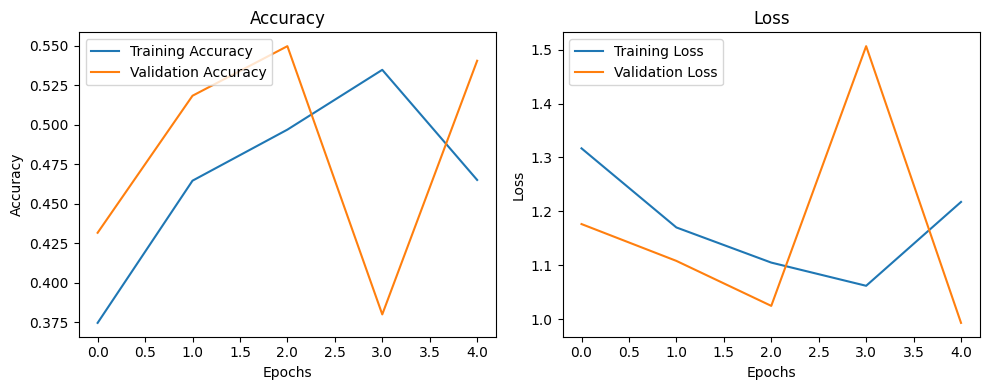

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
text="NASA launches a new satellite into space to study climate change."

seq = tokenizer.texts_to_sequences([text])
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
category = encoder.inverse_transform([np.argmax(pred)])[0]
print(f"Predicted Category: {category}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
Predicted Category: 2


In [ ]:
print(f"Predicted class {categories[category]}")

Predicted class sci.space
